In [1]:
from scipy.io import arff
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import dates
import numpy as np
from sklearn.neighbors import LocalOutlierFactor # not used
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
import seaborn as sns

In [9]:
def k_mean(K, X, title="K-Mean Cluster Plot", xLabel="X axis", yLabel="Y axis"):
    k_model = KMeans(n_clusters=K)
    k_model.fit(X)
    y_pred = k_model.predict(X)
    centroids = k_model.cluster_centers_
    
    %matplotlib inline
    #X = data
    sns.swarmplot(x="class", y="Y Axis", data=X)
    #plt.scatter(X.iloc[:,0],X.iloc[:,1], c=y_pred)
    plt.scatter(centroids[:,0],centroids[:,1], marker='x', s = 200, linewidths=2)
    plt.xlabel(xLabel)
    plt.ylabel(yLabel)
    plt.title(title)
    plt.show()

In [3]:
def find_k_graph(kTests, data):
    # k-means cluster analysis
    clusters=range(1,kTests+1)
    meandist=[]
    
    for k in clusters:
        model=KMeans(n_clusters=k)
        model.fit(data)
        clusassign=model.predict(data)
        meandist.append(sum(np.min(cdist(data, model.cluster_centers_, 'euclidean'), axis=1)) / data.shape[0])
    # Identify number of clusters
    %matplotlib inline
    plt.plot(clusters, meandist)
    plt.xlabel('Number of clusters')
    plt.ylabel('Average distance')
    plt.title('Selecting K with the Elbow Method')

# NSL-KDD Dataset

In [13]:
kddFile = arff.loadarff('KDDTrain+.arff')
kddDF = pd.DataFrame(kddFile[0])
kddDF.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0.0,b'tcp',b'ftp_data',b'SF',491.0,0.0,b'0',0.0,0.0,0.0,...,25.0,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,b'normal'
1,0.0,b'udp',b'other',b'SF',146.0,0.0,b'0',0.0,0.0,0.0,...,1.0,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,b'normal'
2,0.0,b'tcp',b'private',b'S0',0.0,0.0,b'0',0.0,0.0,0.0,...,26.0,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,b'anomaly'
3,0.0,b'tcp',b'http',b'SF',232.0,8153.0,b'0',0.0,0.0,0.0,...,255.0,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,b'normal'
4,0.0,b'tcp',b'http',b'SF',199.0,420.0,b'0',0.0,0.0,0.0,...,255.0,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,b'normal'


In [14]:
kddData = kddDF[['src_bytes', 'dst_bytes', 'num_failed_logins', 'logged_in', 'num_compromised', 
            'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 
            'num_access_files', 'num_outbound_cmds']]
kddData.head()

,src_bytes,dst_bytes,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds
0,491.0,0.0,0.0,b'0',0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,146.0,0.0,0.0,b'0',0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,b'0',0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,232.0,8153.0,0.0,b'1',0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,199.0,420.0,0.0,b'1',0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
find_k_graph(10, kddData)

NameError: name 'find_k_graph' is not defined

In [12]:
k_mean(4, kddData, "K-Mean cluster on NSL-KDD Dataset")

ValueError: Could not interpret input 'X Axis'

# Kaggle Dataset

In [29]:
kaggleDF = pd.read_csv("cs448b_ipasn.csv")
kaggleDF

,date,l_ipn,r_asn,f
0,2006-07-01,0,701,1
1,2006-07-01,0,714,1
2,2006-07-01,0,1239,1
3,2006-07-01,0,1680,1
4,2006-07-01,0,2514,1
5,2006-07-01,0,3320,1
6,2006-07-01,0,3561,13
7,2006-07-01,0,4134,3
8,2006-07-01,0,5617,2
9,2006-07-01,0,6478,1


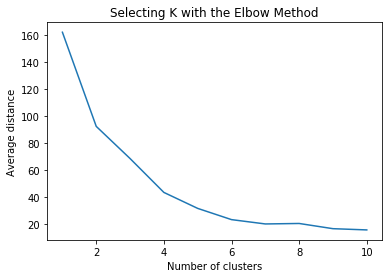

In [9]:
find_k_graph(10, kaggleDF[["l_ipn","f"]])

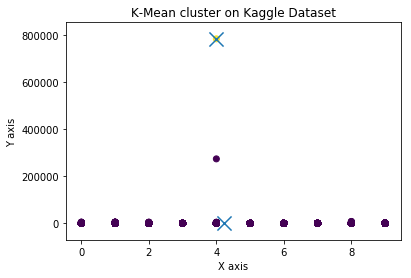

In [10]:
k_mean(2, kaggleDF[["l_ipn","f"]], "K-Mean cluster on Kaggle Dataset")

# CIDDS Dataset

In [37]:
ciddsDF = pd.read_csv("CIDDS-001-internal-week1.csv", low_memory=False)
ciddsDF.head()

,Date first seen,Duration,Proto,Src IP Addr,Src Pt,Dst IP Addr,Dst Pt,Packets,Bytes,Flows,Flags,Tos,class,attackType,attackID,attackDescription
0,2017-03-15 00:01:16.632,0.000,TCP,192.168.100.5,445,192.168.220.16,58844.0,1,108,1,.AP...,0,normal,---,---,---
1,2017-03-15 00:01:16.552,0.000,TCP,192.168.100.5,445,192.168.220.15,48888.0,1,108,1,.AP...,0,normal,---,---,---
2,2017-03-15 00:01:16.551,0.004,TCP,192.168.220.15,48888,192.168.100.5,445.0,2,174,1,.AP...,0,normal,---,---,---
3,2017-03-15 00:01:16.631,0.004,TCP,192.168.220.16,58844,192.168.100.5,445.0,2,174,1,.AP...,0,normal,---,---,---
4,2017-03-15 00:01:16.552,0.000,TCP,192.168.100.5,445,192.168.220.15,48888.0,1,108,1,.AP...,0,normal,---,---,---


In [42]:
feats = ["Src Pt", "Dst Pt", "Packets", "Flows"]

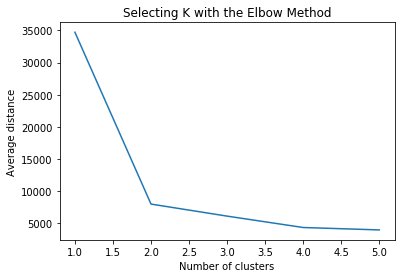

In [43]:
find_k_graph(5, ciddsDF[feats])

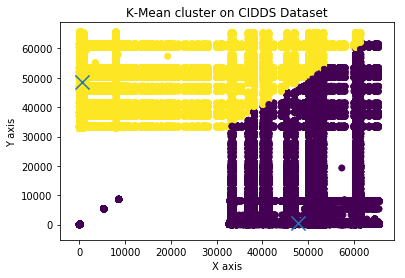

In [44]:
k_mean(2, ciddsDF[feats], "K-Mean cluster on CIDDS Dataset")

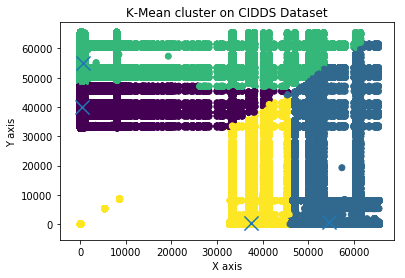

In [45]:
k_mean(4, ciddsDF[feats], "K-Mean cluster on CIDDS Dataset")